In [1]:
import glob
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import warnings
from collections import defaultdict

In [2]:
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [29]:
sorted(glob.glob(osp.join('/home/matthijs/git/rllab-clean/data/s3/ctrnn-swimmer-hill-0.1','*')))

['/home/matthijs/git/rllab-clean/data/s3/ctrnn-swimmer-hill-0.1/ctrnn-swimmer-hill-0.1-0',
 '/home/matthijs/git/rllab-clean/data/s3/ctrnn-swimmer-hill-0.1/ctrnn-swimmer-hill-0.1-1',
 '/home/matthijs/git/rllab-clean/data/s3/ctrnn-swimmer-hill-0.1/ctrnn-swimmer-hill-0.1-2',
 '/home/matthijs/git/rllab-clean/data/s3/ctrnn-swimmer-hill-0.1/ctrnn-swimmer-hill-0.1-3',
 '/home/matthijs/git/rllab-clean/data/s3/ctrnn-swimmer-hill-0.1/ctrnn-swimmer-hill-0.1-4']

In [32]:
def get_results(p):
    dfs = []
    maxval = -1000
    max_ix = -1
    for i, p2 in enumerate(sorted(glob.glob(osp.join(p,'*')))):
        try:
            df = pd.read_csv(osp.join(p2,'progress.csv'))
        except pd.io.common.EmptyDataError as e:
            print("Emptydata for", p2)
            continue
        except Exception as e:
            print("Reading from file", osp.join(p2,'progress.csv'))
            raise e
        dfs.append(df)
        curve = df['MaxReturn'].rolling(window=max(1,int(0.05*df.shape[0])), min_periods=1, center=True).mean().values.flatten()
        if curve.max() > maxval:
            maxval = curve.max()
            max_ix = i
    all_results = pd.concat(dfs)
    mean_results = all_results.groupby(all_results.index).mean()
    try:
        dfs[max_ix].MaxReturn
    except IndexError:
        print(p)
        print(max_ix, len(dfs))
    return mean_results.MaxReturn, dfs[max_ix].MaxReturn

In [14]:
def parse_params(p):
    p = p.replace('-hill', '_hill')
    params = p.split('/')[-1].split('-')
    if len(params) == 4:
        net, env, mode, difficulty = params
    else:
        net, env, difficulty = params
        mode = ''
    if 'hill' not in env:
        difficulty = 0.0
    if len(mode) > 0:
        net = net + '-' + mode
    return net, env + '{0}'.format(difficulty)

In [36]:
result_dict = defaultdict(dict)
all_nets = set()
path_list = glob.glob('/home/matthijs/git/rllab-clean/data/s3/?trnn*') +\
    glob.glob('/home/matthijs/git/rllab-clean/data/s3/lstm*') +\
    glob.glob('/home/matthijs/git/rllab-clean/data/s3/rossler*')
    
for p in path_list:
    net, env = parse_params(p)
    all_nets.add(net)
    mean_result, max_result = get_results(p)
    result_dict[env][net] = (mean_result, max_result)

for k in result_dict.keys():
    for n in all_nets:
        if n not in result_dict[k].keys():
            result_dict[k][n] = ([0],[0])

<IPython.core.display.Javascript object>


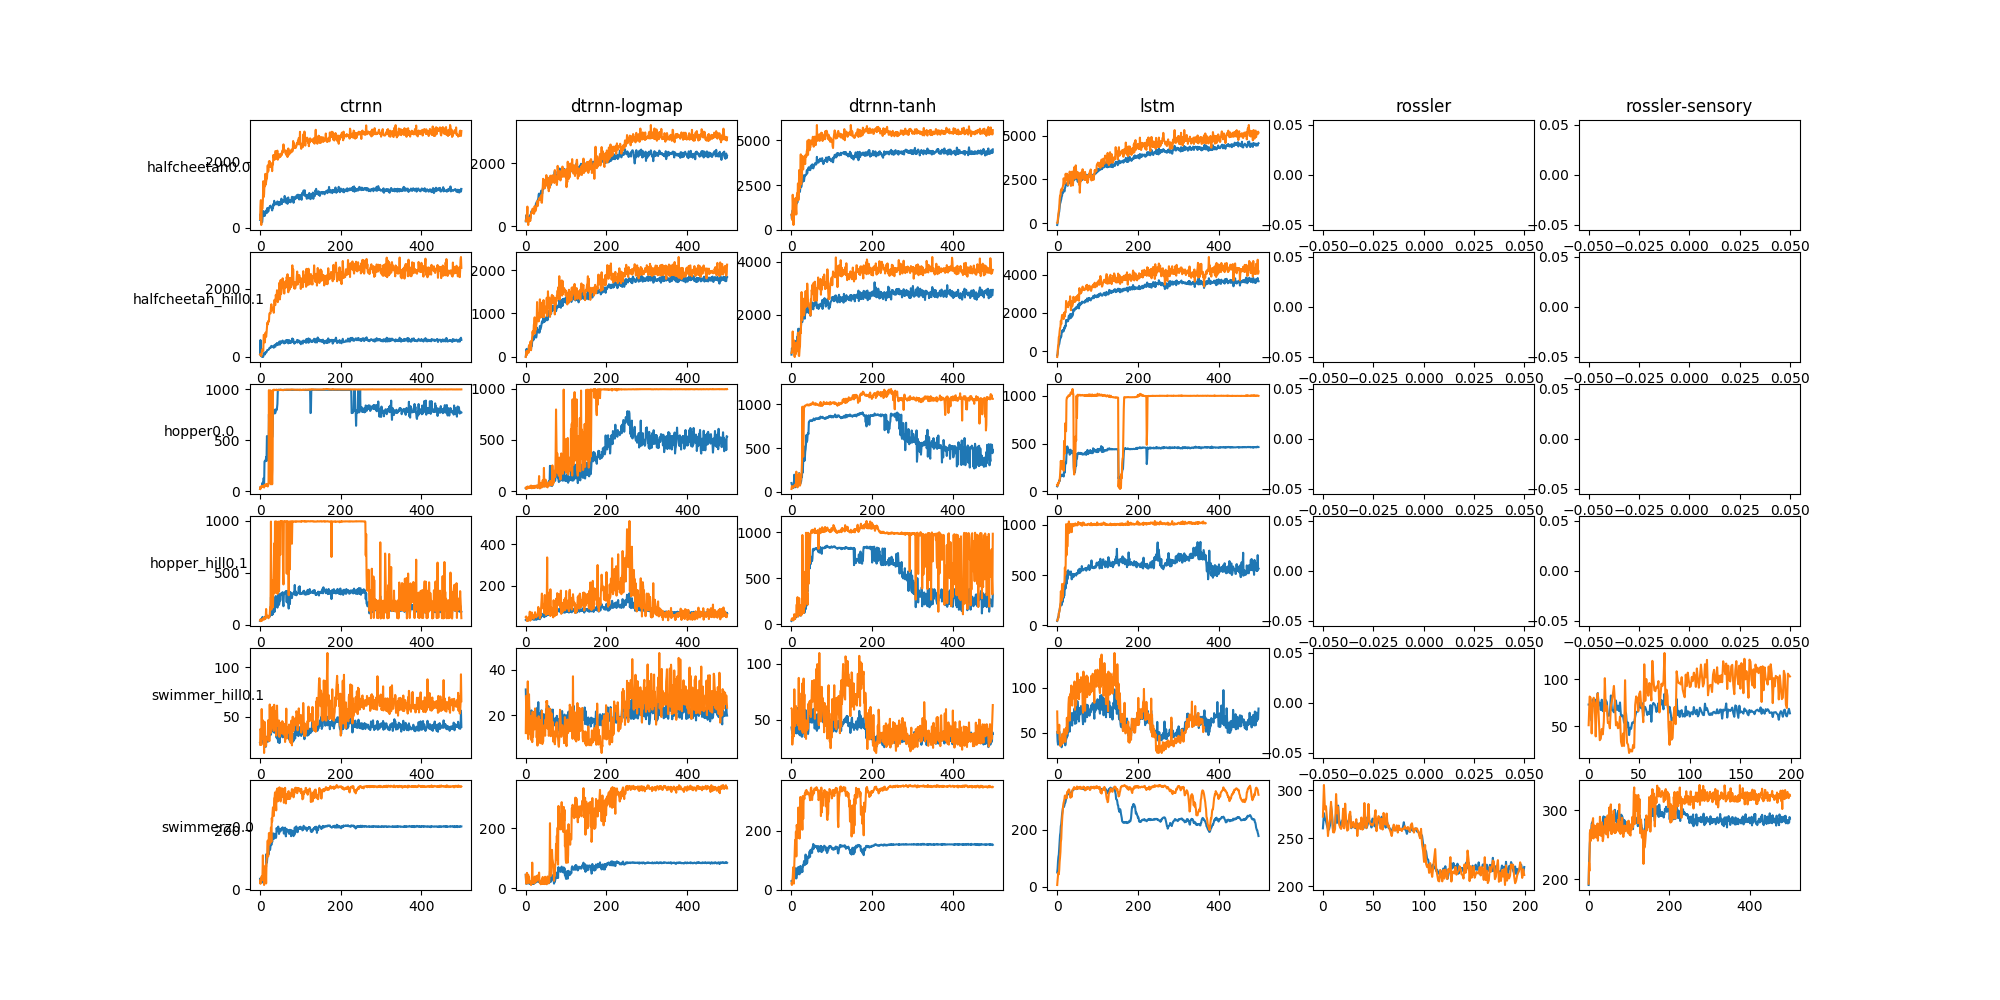

In [37]:
envs = list(sorted(result_dict.keys()))
nets = list(sorted(result_dict[envs[0]].keys()))
numenvs = len(envs)
numnets = len(nets)

data_dict = defaultdict(list)
data_dict['env'] = envs

fig, ax = plt.subplots(numenvs, numnets, figsize=(20,10))
for i, k in enumerate(envs):
    for j, v in enumerate(nets):
        res = result_dict[k][v]
        ax[i,j].plot(res[0])
        ax[i,j].plot(res[1])
        data_dict[v].append(res[1][len(res[1])-1])
        if j == 0:
            h = ax[i,j].set_ylabel(k)
            h.set_rotation(0)
        if i == 0:
            ax[i,j].set_title(v)

In [38]:
pd.DataFrame(data_dict).set_index('env')

,ctrnn,dtrnn-logmap,dtrnn-tanh,lstm,rossler,rossler-sensory
env,,,,,,
halfcheetah0.0,2941.110445,2815.618544,5574.550910,5176.234065,0.000000,0.000000
halfcheetah_hill0.1,2610.809520,2128.213890,3683.949042,4167.176516,0.000000,0.000000
hopper0.0,999.513559,994.464405,1062.174914,1000.196976,0.000000,0.000000
hopper_hill0.1,64.529119,61.642141,984.342522,1018.248898,0.000000,0.000000
swimmer_hill0.1,65.802780,23.329693,63.022309,55.799826,0.000000,102.970655
swimmerz0.0,347.326248,331.304547,348.767752,323.158036,211.764058,321.009352


In [112]:
result_dict['halfcheetah0.0']['ctrnn'][0].mean()

1045.3595531969904

In [48]:
mean_results = all_results.groupby(all_results.index).mean()

<IPython.core.display.Javascript object>


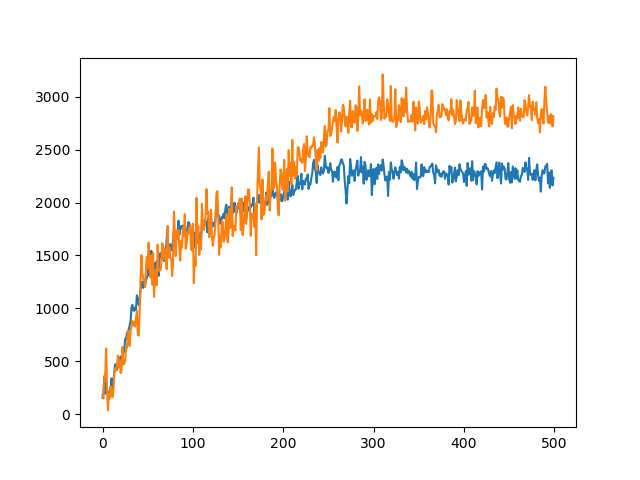

In [53]:
plt.figure()
plt.plot(mean_results.MaxReturn)
plt.plot(dfs[max_ix].MaxReturn)